In [ ]:
pip install tensorflow_federated

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 MB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.8/104.8 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.6/721.6 kB 34.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.7/73.7 MB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 16.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.7/33.7 MB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.2/323.2 kB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.9/489.9 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.9/230.9 kB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.

## Modèle apprentissage en centralisé

Epoch 1/10
452/452 [==============================] - 3s 4ms/step - loss: 0.4720 - binary_accuracy: 0.7963 - precision_1: 0.7726 - recall_1: 0.8447 - auc_1: 0.8696
Epoch 2/10
452/452 [==============================] - 3s 6ms/step - loss: 0.3659 - binary_accuracy: 0.8435 - precision_1: 0.8173 - recall_1: 0.8882 - auc_1: 0.9131
Epoch 3/10
452/452 [==============================] - 3s 6ms/step - loss: 0.3166 - binary_accuracy: 0.8648 - precision_1: 0.8393 - recall_1: 0.9051 - auc_1: 0.9334
Epoch 4/10
452/452 [==============================] - 3s 6ms/step - loss: 0.2922 - binary_accuracy: 0.8800 - precision_1: 0.8499 - recall_1: 0.9253 - auc_1: 0.9445
Epoch 5/10
452/452 [==============================] - 2s 4ms/step - loss: 0.2575 - binary_accuracy: 0.8934 - precision_1: 0.8665 - recall_1: 0.9321 - auc_1: 0.9552
Epoch 6/10
452/452 [==============================] - 2s 4ms/step - loss: 0.2174 - binary_accuracy: 0.9132 - precision_1: 0.8839 - recall_1: 0.9530 - auc_1: 0.9673
Epoch 7/10
452/4

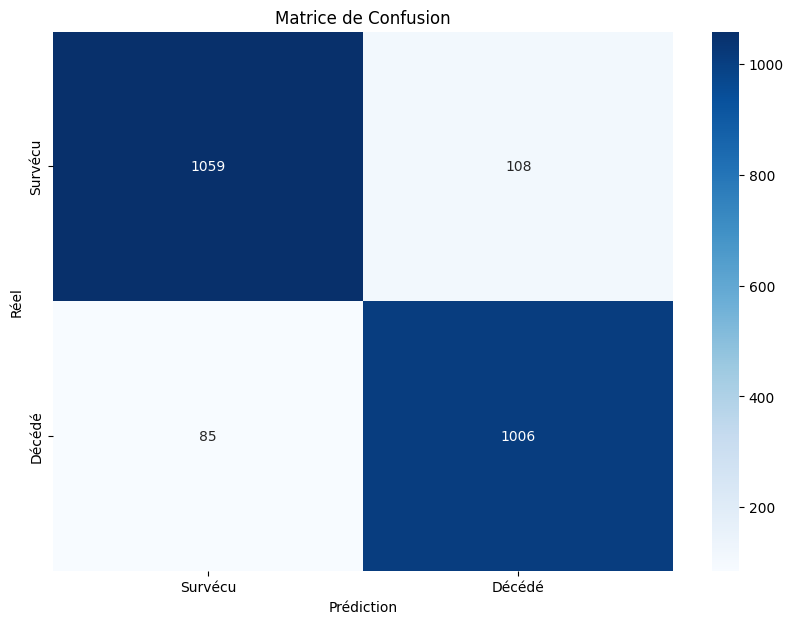

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.preprocessing import PolynomialFeatures
from imblearn.over_sampling import SMOTE
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

# Charger les données
data = pd.read_csv('preprocessed_data.csv')

# Gérer les valeurs manquantes
imputer = SimpleImputer(strategy='mean')
data[['Avg_Heart_Rate', 'Avg_Blood_Pressure', 'Avg_Hemoglobin', 'Avg_Sodium', 'Avg_Potassium', 'Avg_Med_Dose']] = imputer.fit_transform(data[['Avg_Heart_Rate', 'Avg_Blood_Pressure', 'Avg_Hemoglobin', 'Avg_Sodium', 'Avg_Potassium', 'Avg_Med_Dose']])

# Encoder les variables catégorielles
encoder = LabelEncoder()
data['Gender'] = encoder.fit_transform(data['Gender'])
data['Admission_Type'] = encoder.fit_transform(data['Admission_Type'])

# Créer des caractéristiques polynomiales
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
poly_features = poly.fit_transform(data.drop(columns=['Hospital_Expire_Flag']))
poly_feature_names = poly.get_feature_names_out(data.drop(columns=['Hospital_Expire_Flag']).columns)
poly_df = pd.DataFrame(poly_features, columns=poly_feature_names)

# Normaliser les données
scaler = StandardScaler()
scaled_features = scaler.fit_transform(poly_df)

# Préparer le jeu de données final
X = pd.DataFrame(scaled_features, columns=poly_feature_names)
y = data['Hospital_Expire_Flag']

# Traiter le déséquilibre des classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Créer et compiler le modèle Keras
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(),
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall(),
                       tf.keras.metrics.AUC()])

# Entraîner le modèle
model.fit(X_train, y_train, epochs=10, batch_size=20)

# Évaluer le modèle sur les données de test
loss, accuracy, precision, recall, auc = model.evaluate(X_test, y_test, verbose=0)
print(f'Loss: {loss}, Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, AUC: {auc}')

y_pred_proba = model.predict(X_test).ravel()
y_pred = (y_pred_proba > 0.5).astype(int)
y_true = y_test.values

print(classification_report(y_true, y_pred))
print(f'ROC AUC: {roc_auc_score(y_true, y_pred_proba)}')

# Matrice de confusion
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Survécu', 'Décédé'], yticklabels=['Survécu', 'Décédé'])
plt.xlabel('Prédiction')
plt.ylabel('Réel')
plt.title('Matrice de Confusion')
plt.show()


## Modèle d'apprentissage fédéré

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.preprocessing import PolynomialFeatures
from imblearn.over_sampling import SMOTE
import tensorflow as tf
import tensorflow_federated as tff
import matplotlib.pyplot as plt
import seaborn as sns

# Charger les données
data = pd.read_csv('preprocessed_data.csv')

# Gérer les valeurs manquantes
imputer = SimpleImputer(strategy='mean')
data[['Avg_Heart_Rate', 'Avg_Blood_Pressure', 'Avg_Hemoglobin', 'Avg_Sodium', 'Avg_Potassium', 'Avg_Med_Dose']] = imputer.fit_transform(data[['Avg_Heart_Rate', 'Avg_Blood_Pressure', 'Avg_Hemoglobin', 'Avg_Sodium', 'Avg_Potassium', 'Avg_Med_Dose']])

# Encoder les variables catégorielles
encoder = LabelEncoder()
data['Gender'] = encoder.fit_transform(data['Gender'])
data['Admission_Type'] = encoder.fit_transform(data['Admission_Type'])

# Créer des caractéristiques polynomiales
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
poly_features = poly.fit_transform(data.drop(columns=['Hospital_Expire_Flag']))
poly_feature_names = poly.get_feature_names_out(data.drop(columns=['Hospital_Expire_Flag']).columns)
poly_df = pd.DataFrame(poly_features, columns=poly_feature_names)

# Normaliser les données
scaler = StandardScaler()
scaled_features = scaler.fit_transform(poly_df)

# Préparer le jeu de données final
X = pd.DataFrame(scaled_features, columns=poly_feature_names)
y = data['Hospital_Expire_Flag']

# Traiter le déséquilibre des classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Diviser les données pour l'apprentissage fédéré (simulation de différents nœuds)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
node1_data = (X_train[:len(X_train)//2], y_train[:len(y_train)//2])
node2_data = (X_train[len(X_train)//2:], y_train[len(y_train)//2:])

# Créer une fonction de prétraitement pour les données TFF
def preprocess(dataset):
    def batch_format_fn(element):
        return (tf.reshape(element['x'], [-1, X_train.shape[1]]), tf.reshape(element['y'], [-1, 1]))

    return dataset.repeat(1).shuffle(len(dataset)).batch(20).map(batch_format_fn)

# Convertir nos données en ensembles de données TFF
def make_federated_data(data):
    return [preprocess(tf.data.Dataset.from_tensor_slices({'x': X, 'y': y})) for X, y in data]

federated_train_data = make_federated_data([node1_data, node2_data])

# Créer le modèle Keras
def create_keras_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

# Fonction de modèle pour TFF
def model_fn():
    keras_model = create_keras_model()
    return tff.learning.models.from_keras_model(
        keras_model,
        input_spec=federated_train_data[0].element_spec,
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=[
            tf.keras.metrics.BinaryAccuracy(),
            tf.keras.metrics.Precision(),
            tf.keras.metrics.Recall(),
            tf.keras.metrics.AUC()
        ]
    )

# Définir un processus de moyenne fédérée
iterative_process = tff.learning.algorithms.build_weighted_fed_avg(
    model_fn=model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.Adam(learning_rate=0.001),
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1.0)
)

# Initialiser le processus
state = iterative_process.initialize()

# Boucle d'entraînement avec scheduler de taux d'apprentissage
NUM_ROUNDS = 50
for round_num in range(1, NUM_ROUNDS + 1):
    state, metrics = iterative_process.next(state, federated_train_data)
    print(f'Round {round_num}, Metrics={metrics}')

# Évaluer le modèle sur les données de test
def evaluate_model_on_test_data(state, test_data):
    keras_model = create_keras_model()
    keras_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                        loss=tf.keras.losses.BinaryCrossentropy(),
                        metrics=[
                            tf.keras.metrics.BinaryAccuracy(),
                            tf.keras.metrics.Precision(),
                            tf.keras.metrics.Recall(),
                            tf.keras.metrics.AUC()
                        ])

    model_weights = iterative_process.get_model_weights(state)
    keras_model.set_weights(model_weights.trainable)

    loss, accuracy, precision, recall, auc = keras_model.evaluate(test_data, verbose=0)

    y_pred_proba = keras_model.predict(test_data).ravel()
    y_pred = (y_pred_proba > 0.5).astype(int)
    y_true = y_test.values

    print(f'Loss: {loss}, Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, AUC: {auc}')
    print(classification_report(y_true, y_pred))
    print(f'ROC AUC: {roc_auc_score(y_true, y_pred_proba)}')

    # Matrice de confusion
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Survécu', 'Décédé'], yticklabels=['Survécu', 'Décédé'])
    plt.xlabel('Prédiction')
    plt.ylabel('Réel')
    plt.title('Matrice de Confusion')
    plt.show()

# Préparer les données de test
test_data = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(20)

# Évaluer le modèle
evaluate_model_on_test_data(state, test_data)


## Suppression de gradient

In [ ]:
# Paramètres du modèle malicieux avec une augmentation plus élevée des valeurs négatives
def distribute_parameters(target_index, num_clients):
    client_params = []
    for i in range(num_clients):
        if i == target_index:
            client_params.append(create_advanced_model().get_weights())  # Modèle correct
        else:
            malicious_model = create_advanced_model()
            # Paramètres malicieux pour supprimer les gradients
            malicious_model.set_weights([np.full_like(w, -1e8) if w.ndim > 1 else np.full_like(w, -1e8) for w in malicious_model.get_weights()])
            client_params.append(malicious_model.get_weights())
    return client_params

# Entraîner les modèles locaux avec paramètres malicieux
def train_local_models(state, num_rounds, target_index):
    for round_num in range(num_rounds):
        client_params = distribute_parameters(target_index, len(clients))
        state, metrics = iterative_process.next(state, federated_train_data)
        print(f'Round {round_num + 1}, Metrics: {metrics}')
    return state

# Nombre de rounds
state = train_local_models(state, num_rounds=5, target_index=0)

# Extraire les gradients du client cible
target_client_data = federated_train_data[0]
target_model = create_advanced_model()

# Entraîner le modèle cible et capturer les gradients
@tf.function
def get_gradients(x, y):
    with tf.GradientTape() as tape:
        predictions = target_model(x, training=True)
        loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(y, predictions)
    gradients = tape.gradient(loss, target_model.trainable_variables)
    return gradients

gradients = []
for batch in target_client_data:
    x, y = batch
    gradients.append(get_gradients(x, y))

# Ajouter une condition pour écarter les valeurs de gradients faibles
threshold = 1e-1

def filter_gradients(gradients, threshold):
    return [tf.where(tf.abs(g) < threshold, 0.0, g) for g in gradients]

filtered_gradients = [filter_gradients(grad, threshold) for grad in gradients]

# Afficher quelques gradients des clients non-cibles pour vérifier qu'ils sont bien nuls
print("Gradients des clients non-cibles (attendus à zéro):")
for grad in filtered_gradients[:2]:  # Limiter l'affichage à 2 lots de données
    for i, g in enumerate(grad):
        if i < 2:  # Afficher uniquement les gradients des 2 premières couches
            print(f"Lot {i+1}, Couche {i+1}:", g.numpy()[:5])  # Afficher les 5 premiers gradients

# Capturer les gradients du client cible
print("\nGradients du client cible:")
for grad in gradients[:2]:  # Limiter l'affichage à 2 lots de données
    for i, g in enumerate(grad):
        if i < 2:  # Afficher uniquement les gradients des 2 premières couches
            print(f"Lot {i+1}, Couche {i+1}:", g.numpy()[:5])  # Afficher les 5 premiers gradients

# Appliquer les poids agrégés au modèle global
global_model = create_advanced_model()
model_weights = iterative_process.get_model_weights(state)
global_model.set_weights(model_weights.trainable)

# Évaluation du modèle global
y_pred_prob = global_model.predict(X_test).flatten()
y_pred = (y_pred_prob > 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_prob)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"AUC: {auc}")


Round 1, Metrics: OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('binary_accuracy', 0.98947954), ('precision', 0.98924494), ('recall', 0.9898968), ('auc', 0.99730366), ('loss', 0.04609785), ('num_examples', 9030), ('num_batches', 452)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))])
Round 2, Metrics: OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('binary_accuracy', 0.98826134), ('precision', 0.98750275), ('recall', 0.98923784), ('auc', 0.9971602), ('loss', 0.0492429), ('num_examples', 9030), ('num_batches', 452)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))])
Round 3, Metrics: OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('binary_accuracy', 0.9893688), ('precision', 0.9892426), ('recall', 0.9896

/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5820: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Gradients des clients non-cibles (attendus à zéro):
Lot 1, Couche 1: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Lot 2, Couche 2: [0. 0. 0. 0. 0.]
Lot 1, Couche 1: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Lot 2, Couche 2: [0. 0. 0. 0. 0.]

Gradients du client cible:
Lot 1, Couche 1: [[ 0.00142043 -0.0025054  -0.01509289 ...  0.02374392  0.01632271
  -0.01631634]
 [ 0.00241196 -0.00179392 -0.00505783 ... -0.02102598 -0.00540606
   0.03126261]
 [ 0.00208199  0.00764025  0.00828738 ...  0.01407738  0.01507898
  -0.02649288]
 [-0.0016756  -0.00654223 -0.00776049 ... -0.00965835  0.00555155
   0.00629163]
 [ 0.00141335 -0.0015906   0.00290598 ... -0.02377002  0.01253163
  -0.00349473]]
Lot 2, Couche 2: [ 0.0020505  -0.00230767  0.00393182 -0.00918051  0.00178854]
Lot 1, Couche 1: [[ 0.00235835 -0.00513693 -0.01636549 ...  0.00

## a

In [ ]:
# Initialiser le modèle malveillant
def small_negative_initializer(shape, dtype=None):
    return tf.random.uniform(shape, minval=-0.01, maxval=0.0, dtype=dtype)

def large_negative_initializer(shape, dtype=None):
    return tf.constant(-1000.0, shape=shape, dtype=dtype)

# Modèle avancé (cible)
def create_advanced_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

# Modèle malveillant
def create_malicious_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],),
                              kernel_initializer=small_negative_initializer,
                              bias_initializer=large_negative_initializer),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation='relu',
                              kernel_initializer=small_negative_initializer,
                              bias_initializer=large_negative_initializer),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(64, activation='relu',
                              kernel_initializer=small_negative_initializer,
                              bias_initializer=large_negative_initializer),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

# Définir le model_fn pour TFF
def model_fn():
    keras_model = create_advanced_model()
    return tff.learning.models.from_keras_model(
        keras_model,
        input_spec=federated_train_data[0].element_spec,
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=[
            tf.keras.metrics.BinaryAccuracy(),
            tf.keras.metrics.Precision(),
            tf.keras.metrics.Recall(),
            tf.keras.metrics.AUC()
        ]
    )

# Initialiser le processus de moyenne fédérée
iterative_process = tff.learning.algorithms.build_weighted_fed_avg(
    model_fn=model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.Adam(learning_rate=0.001),
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1.0)
)

state = iterative_process.initialize()

# Paramètres du modèle malicieux
def distribute_parameters(target_index, num_clients):
    client_params = []
    for i in range(num_clients):
        if i == target_index:
            client_params.append(create_advanced_model().get_weights())  # Modèle correct
        else:
            malicious_model = create_malicious_model()
            client_params.append(malicious_model.get_weights())
    return client_params

# Entraîner les modèles locaux avec paramètres malicieux
class GradientCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch == (self.params['epochs'] - 1):
            with tf.GradientTape() as tape:
                logits = target_model(tf.convert_to_tensor(X_train[:32]), training=True)
                loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
                loss_value = loss_fn(tf.convert_to_tensor(y_train[:32]), logits)
            grads = tape.gradient(loss_value, target_model.trainable_variables)
            self.grads = grads
            self.weights = target_model.get_weights()

gradient_callback = GradientCallback()

def train_local_models(state, num_rounds, target_index):
    for round_num in range(num_rounds):
        client_params = distribute_parameters(target_index, len(clients))
        state, metrics = iterative_process.next(state, federated_train_data)
        print(f'Round {round_num + 1}, Metrics: {metrics}')
    return state

# Nombre de rounds
state = train_local_models(state, num_rounds=10, target_index=0)

# Extraire les gradients du client cible
target_client_data = federated_train_data[0]
target_model = create_advanced_model()
target_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=[tf.keras.metrics.BinaryAccuracy()])

# Entraîner le modèle cible et capturer les gradients
history = target_model.fit(X_train.values, y_train.values, epochs=1, batch_size=32, validation_data=(X_test.values, y_test.values), callbacks=[gradient_callback])

# Afficher les gradients des clients non-cibles pour vérifier qu'ils sont nuls
non_target_client_data = federated_train_data[1]
non_target_gradients = []
for batch in non_target_client_data:
    x, y = batch
    non_target_gradients.append(get_gradients(x, y))

print("\nGradients des clients non-cibles (attendus à zéro):")
for i, grad in enumerate(non_target_gradients[:2]):  # Limiter l'affichage à quelques lots
    for layer_index, layer in enumerate(grad[:2]):  # Limiter l'affichage à quelques couches
        print(f"Lot {i+1}, Couche {layer_index+1}: {layer.numpy()}")

print("\nGradients du client cible:")
for i, grad in enumerate(gradient_callback.grads[:2]):  # Limiter l'affichage à quelques lots
    for layer_index, layer in enumerate(grad[:2]):  # Limiter l'affichage à quelques couches
        print(f"Lot {i+1}, Couche {layer_index+1}: {layer.numpy()}")

# Appliquer les poids agrégés au modèle global
global_model = create_advanced_model()
model_weights = iterative_process.get_model_weights(state)
global_model.set_weights(model_weights.trainable)

# Préparer les données de test pour l'évaluation
test_data = tf.data.Dataset.from_tensor_slices((X_test.values, y_test.values)).batch(20)

# Évaluation du modèle global
y_pred_prob = global_model.predict(test_data).flatten()
y_pred = (y_pred_prob > 0.5).astype(int)

# Vérification des dimensions pour l'évaluation
print(f"Dimensions de y_test: {len(y_test)}, Dimensions de y_pred: {len(y_pred)}")

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_prob)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"AUC: {auc}")


NameError: name 'tff' is not defined

## Attaque par inférence de Source
(Code modifié pour encourgaer le surapprentissage)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.preprocessing import PolynomialFeatures
from imblearn.over_sampling import SMOTE
import tensorflow as tf
import tensorflow_federated as tff
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Charger et prétraiter les données
data = pd.read_csv('preprocessed_data.csv')

# Gérer les valeurs manquantes
imputer = SimpleImputer(strategy='mean')
columns_to_impute = ['Avg_Heart_Rate', 'Avg_Blood_Pressure', 'Avg_Hemoglobin', 'Avg_Sodium', 'Avg_Potassium', 'Avg_Med_Dose']
data[columns_to_impute] = imputer.fit_transform(data[columns_to_impute])

# Encoder les variables catégorielles
encoder = LabelEncoder()
data['Gender'] = encoder.fit_transform(data['Gender'])
data['Admission_Type'] = encoder.fit_transform(data['Admission_Type'])

# Générer des features polynomiaux
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
poly_features = poly.fit_transform(data.drop(columns=['Hospital_Expire_Flag']))
poly_feature_names = poly.get_feature_names_out(data.drop(columns=['Hospital_Expire_Flag']).columns)
poly_df = pd.DataFrame(poly_features, columns=poly_feature_names)

# Normaliser les données
scaler = StandardScaler()
scaled_features = scaler.fit_transform(poly_df)

# Préparer le dataset final
X = pd.DataFrame(scaled_features, columns=poly_feature_names)
y = data['Hospital_Expire_Flag']

# Gérer le déséquilibre des classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Créer des distributions de données hétérogènes
X_resampled_node1 = X_resampled[y_resampled == 0].sample(frac=0.7, random_state=42)
y_resampled_node1 = y_resampled[y_resampled == 0].sample(frac=0.7, random_state=42)
X_resampled_node2 = X_resampled[y_resampled == 1].sample(frac=0.3, random_state=42)
y_resampled_node2 = y_resampled[y_resampled == 1].sample(frac=0.3, random_state=42)

X_train_node1, X_test_node1, y_train_node1, y_test_node1 = train_test_split(X_resampled_node1, y_resampled_node1, test_size=0.1, random_state=42)
X_train_node2, X_test_node2, y_train_node2, y_test_node2 = train_test_split(X_resampled_node2, y_resampled_node2, test_size=0.1, random_state=42)

node1_data = (X_train_node1, y_train_node1)
node2_data = (X_train_node2, y_train_node2)

# Calculer le poids de chaque client basé sur la taille de l'ensemble de données
node1_weight = len(y_train_node1) / (len(y_train_node1) + len(y_train_node2))
node2_weight = len(y_train_node2) / (len(y_train_node1) + len(y_train_node2))

print(f'Poids du Nœud 1 : {node1_weight}')
print(f'Poids du Nœud 2 : {node2_weight}')

# Définir une fonction de prétraitement pour TFF
def preprocess(dataset):
    def batch_format_fn(element):
        return (tf.reshape(element['x'], [-1, X_train_node1.shape[1]]), tf.reshape(element['y'], [-1, 1]))
    return dataset.repeat(1).shuffle(len(dataset)).batch(20).map(batch_format_fn)

# Convertir les données au format TFF
def make_federated_data(data):
    return [preprocess(tf.data.Dataset.from_tensor_slices({'x': X, 'y': y})) for X, y in data]

federated_train_data = make_federated_data([node1_data, node2_data])

# Créer un modèle Keras
def create_keras_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(512, activation='relu', input_shape=(X_train_node1.shape[1],)),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

# Fonction de modèle pour TFF
def model_fn():
    keras_model = create_keras_model()
    return tff.learning.models.from_keras_model(
        keras_model,
        input_spec=federated_train_data[0].element_spec,
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=[
            tf.keras.metrics.BinaryAccuracy(),
            tf.keras.metrics.Precision(),
            tf.keras.metrics.Recall(),
            tf.keras.metrics.AUC()
        ]
    )

# Définir le processus de moyenne fédérée
iterative_process = tff.learning.algorithms.build_weighted_fed_avg(
    model_fn=model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.Adam(learning_rate=0.001),
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1.0)
)

# Initialiser le processus
state = iterative_process.initialize()

# Entraîner le modèle pour un nombre spécifié de tours
NUM_ROUNDS = 100
for round_num in range(1, NUM_ROUNDS + 1):
    state, metrics = iterative_process.next(state, federated_train_data)
    print(f'Round {round_num}, Metrics={metrics}')




Round 1, Metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('binary_accuracy', 0.9964553), ('precision', 0.99801457), ('recall', 0.990151), ('auc', 0.999973), ('loss', 0.012470196), ('num_examples', 5078), ('num_batches', 255)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))])
Round 2, Metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('binary_accuracy', 0.98129183), ('precision', 1.0), ('recall', 0.9376231), ('auc', 0.9842416), ('loss', 0.110218674), ('num_examples', 5078), ('num_batches', 255)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))])
Round 3, Metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('binary_accuracy', 0.9921229), ('precision', 1.0), ('recall', 0.97373605), ('auc', 0.9

In [ ]:
# Évaluer la confiance des prédictions sur les données des deux clients
def get_prediction_confidence(model, data):
    predictions = model.predict(data)
    rounded_predictions = np.round(predictions)
    confidence = np.abs(predictions - rounded_predictions)
    return confidence

# Créer un modèle Keras et définir les poids entraînés
keras_model = create_keras_model()
model_weights = iterative_process.get_model_weights(state)
keras_model.set_weights(model_weights.trainable)

# Obtenir la confiance des prédictions pour les données de node1 et node2
node1_confidence = get_prediction_confidence(keras_model, X_test_node1)
node2_confidence = get_prediction_confidence(keras_model, X_test_node2)

# Calculer la moyenne et la variance de la confiance des prédictions pour les deux nœuds
node1_confidence_mean = np.mean(node1_confidence)
node1_confidence_variance = np.var(node1_confidence)
node2_confidence_mean = np.mean(node2_confidence)
node2_confidence_variance = np.var(node2_confidence)

print(f'Nœud 1 - Confiance Moyenne : {node1_confidence_mean}, Variance : {node1_confidence_variance}')
print(f'Nœud 2 - Confiance Moyenne : {node2_confidence_mean}, Variance : {node2_confidence_variance}')

# Définir un seuil pour la confiance des prédictions afin d'inférer la source des données
seuil_de_confiance = (node1_confidence_mean + node2_confidence_mean) / 2

def inférer_source_données(confiance, seuil):
    if confiance < seuil:
        return 'Nœud 1'
    else:
        return 'Nœud 2'

# Évaluer l'attaque sur les données de test
test_confidence_node1 = get_prediction_confidence(keras_model, X_test_node1)
test_confidence_node2 = get_prediction_confidence(keras_model, X_test_node2)

# Combiner les confiances des tests et les sources réelles
test_confidences = np.concatenate([test_confidence_node1, test_confidence_node2])
actual_sources = np.array(['Nœud 1'] * len(test_confidence_node1) + ['Nœud 2'] * len(test_confidence_node2))
inferred_sources = np.array([inférer_source_données(conf, seuil_de_confiance) for conf in test_confidences])

# Calculer l'exactitude de l'attaque SIA
correct_predictions = np.sum(inferred_sources == actual_sources)
total_predictions = len(actual_sources)
accuracy = np.mean(inferred_sources == actual_sources)

print(f'Exactitude de l\'attaque SIA : {accuracy}')
print(f'Nombre de prédictions correctes : {correct_predictions} sur un total de {total_predictions}')



6/6 [==============================] - 0s 3ms/step
Nœud 1 - Confiance Moyenne : 0.02495628409087658, Variance : 0.005649239290505648
Nœud 2 - Confiance Moyenne : 0.1392412632703781, Variance : 0.02181650698184967
6/6 [==============================] - 0s 3ms/step
Exactitude de l'attaque SIA : 0.7826855123674912
Nombre de prédictions correctes : 443 sur un total de 566


## SIA 5 clients
(2 configurations pour le poids des clients)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.preprocessing import PolynomialFeatures
from imblearn.over_sampling import SMOTE
import tensorflow as tf
import tensorflow_federated as tff
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Charger et prétraiter les données
data = pd.read_csv('preprocessed_data.csv')

# Gérer les valeurs manquantes
imputer = SimpleImputer(strategy='mean')
columns_to_impute = ['Avg_Heart_Rate', 'Avg_Blood_Pressure', 'Avg_Hemoglobin', 'Avg_Sodium', 'Avg_Potassium', 'Avg_Med_Dose']
data[columns_to_impute] = imputer.fit_transform(data[columns_to_impute])

# Encoder les variables catégorielles
encoder = LabelEncoder()
data['Gender'] = encoder.fit_transform(data['Gender'])
data['Admission_Type'] = encoder.fit_transform(data['Admission_Type'])

# Générer des features polynomiaux
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
poly_features = poly.fit_transform(data.drop(columns=['Hospital_Expire_Flag']))
poly_feature_names = poly.get_feature_names_out(data.drop(columns=['Hospital_Expire_Flag']).columns)
poly_df = pd.DataFrame(poly_features, columns=poly_feature_names)

# Normaliser les données
scaler = StandardScaler()
scaled_features = scaler.fit_transform(poly_df)

# Préparer le dataset final
X = pd.DataFrame(scaled_features, columns=poly_feature_names)
y = data['Hospital_Expire_Flag']

# Gérer le déséquilibre des classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Créer des distributions de données hétérogènes pour 5 clients
fractions = [0.5, 0.3, 0.1, 0.07, 0.03]  # Example fractions for 5 clients
X_resampled_clients = []
y_resampled_clients = []

for frac in fractions:
    X_resampled_clients.append(X_resampled[y_resampled == 1].sample(frac=frac, random_state=42))
    y_resampled_clients.append(y_resampled[y_resampled == 1].sample(frac=frac, random_state=42))

for i, frac in enumerate(fractions):
    X_resampled_clients[i] = pd.concat([X_resampled_clients[i], X_resampled[y_resampled == 0].sample(frac=frac, random_state=42)])
    y_resampled_clients[i] = pd.concat([y_resampled_clients[i], y_resampled[y_resampled == 0].sample(frac=frac, random_state=42)])

# Split data into training and testing sets for each client
train_test_splits = [train_test_split(X, y, test_size=0.1, random_state=42) for X, y in zip(X_resampled_clients, y_resampled_clients)]

clients_data = [(X_train, y_train) for X_train, X_test, y_train, y_test in train_test_splits]

# Calculer le poids de chaque client basé sur la taille de l'ensemble de données
clients_weights = [len(y_train) / sum(len(y_train) for _, y_train in clients_data) for _, y_train in clients_data]

for i, weight in enumerate(clients_weights):
    print(f'Poids du Nœud {i + 1} : {weight}')

# Définir une fonction de prétraitement pour TFF
def preprocess(dataset):
    def batch_format_fn(element):
        return (tf.reshape(element['x'], [-1, clients_data[0][0].shape[1]]), tf.reshape(element['y'], [-1, 1]))
    return dataset.repeat(1).shuffle(len(dataset)).batch(20).map(batch_format_fn)

# Convertir les données au format TFF
def make_federated_data(data):
    return [preprocess(tf.data.Dataset.from_tensor_slices({'x': X, 'y': y})) for X, y in data]

federated_train_data = make_federated_data(clients_data)

# Créer un modèle Keras
def create_keras_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(512, activation='relu', input_shape=(clients_data[0][0].shape[1],)),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

# Fonction de modèle pour TFF
def model_fn():
    keras_model = create_keras_model()
    return tff.learning.models.from_keras_model(
        keras_model,
        input_spec=federated_train_data[0].element_spec,
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=[
            tf.keras.metrics.BinaryAccuracy(),
            tf.keras.metrics.Precision(),
            tf.keras.metrics.Recall(),
            tf.keras.metrics.AUC()
        ]
    )

# Définir le processus de moyenne fédérée
iterative_process = tff.learning.algorithms.build_weighted_fed_avg(
    model_fn=model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.Adam(learning_rate=0.001),
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1.0)
)

# Initialiser le processus
state = iterative_process.initialize()

# Entraîner le modèle pour un nombre spécifié de tours
NUM_ROUNDS = 100
for round_num in range(1, NUM_ROUNDS + 1):
    state, metrics = iterative_process.next(state, federated_train_data)
    print(f'Round {round_num}, Metrics={metrics}')


# Évaluer la confiance des prédictions sur les données des cinq clients
def get_prediction_confidence(model, data):
    predictions = model.predict(data)
    rounded_predictions = np.round(predictions)
    confidence = np.abs(predictions - rounded_predictions)
    return confidence

# Créer un modèle Keras et définir les poids entraînés
keras_model = create_keras_model()
model_weights = iterative_process.get_model_weights(state)
keras_model.set_weights(model_weights.trainable)

# Obtenir la confiance des prédictions pour les données de chaque nœud
clients_confidence = [get_prediction_confidence(keras_model, X_test) for X_train, X_test, y_train, y_test in train_test_splits]

# Calculer la moyenne et la variance de la confiance des prédictions pour les cinq nœuds
for i, confidence in enumerate(clients_confidence):
    confidence_mean = np.mean(confidence)
    confidence_variance = np.var(confidence)
    print(f'Nœud {i + 1} - Confiance Moyenne : {confidence_mean}, Variance : {confidence_variance}')

# Définir un seuil pour la confiance des prédictions afin d'inférer la source des données
seuil_de_confiance = np.mean([np.mean(confidence) for confidence in clients_confidence])

def inférer_source_données(confiance, seuil):
    return np.argmin([np.abs(conf - seuil) for conf in confiance])

# Évaluer l'attaque sur les données de test
test_confidences = np.concatenate(clients_confidence)
actual_sources = np.concatenate([np.full(len(conf), i) for i, conf in enumerate(clients_confidence)])
inferred_sources = np.array([inférer_source_données(conf, seuil_de_confiance) for conf in test_confidences])

# Calculer l'exactitude de l'attaque SIA
correct_predictions = np.sum(inferred_sources == actual_sources)
total_predictions = len(actual_sources)
accuracy = np.mean(inferred_sources == actual_sources)

print(f'Exactitude de l\'attaque SIA : {accuracy}')
print(f'Nombre de prédictions correctes : {correct_predictions} sur un total de {total_predictions}')


Poids du Nœud 1 : 0.5000984639621898
Poids du Nœud 2 : 0.30001969279243795
Poids du Nœud 3 : 0.0999409216226861
Poids du Nœud 4 : 0.07000787711697519
Poids du Nœud 5 : 0.02993304450571091
Round 1, Metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('binary_accuracy', 0.774616), ('precision', 0.7537493), ('recall', 0.80934393), ('auc', 0.849861), ('loss', 0.4849013), ('num_examples', 10156), ('num_batches', 510)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))])
Round 2, Metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('binary_accuracy', 0.8215833), ('precision', 0.80210286), ('recall', 0.8493042), ('auc', 0.89420694), ('loss', 0.41559625), ('num_examples', 10156), ('num_batches', 510)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)])

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.preprocessing import PolynomialFeatures
from imblearn.over_sampling import SMOTE
import tensorflow as tf
import tensorflow_federated as tff
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Charger et prétraiter les données
data = pd.read_csv('preprocessed_data.csv')

# Gérer les valeurs manquantes
imputer = SimpleImputer(strategy='mean')
columns_to_impute = ['Avg_Heart_Rate', 'Avg_Blood_Pressure', 'Avg_Hemoglobin', 'Avg_Sodium', 'Avg_Potassium', 'Avg_Med_Dose']
data[columns_to_impute] = imputer.fit_transform(data[columns_to_impute])

# Encoder les variables catégorielles
encoder = LabelEncoder()
data['Gender'] = encoder.fit_transform(data['Gender'])
data['Admission_Type'] = encoder.fit_transform(data['Admission_Type'])

# Générer des features polynomiaux
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
poly_features = poly.fit_transform(data.drop(columns=['Hospital_Expire_Flag']))
poly_feature_names = poly.get_feature_names_out(data.drop(columns=['Hospital_Expire_Flag']).columns)
poly_df = pd.DataFrame(poly_features, columns=poly_feature_names)

# Normaliser les données
scaler = StandardScaler()
scaled_features = scaler.fit_transform(poly_df)

# Préparer le dataset final
X = pd.DataFrame(scaled_features, columns=poly_feature_names)
y = data['Hospital_Expire_Flag']

# Gérer le déséquilibre des classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Créer des distributions de données hétérogènes pour 5 clients
fractions = [0.7, 0.2, 0.08, 0.015, 0.005]  # Example fractions for 5 clients
X_resampled_clients = []
y_resampled_clients = []

for frac in fractions:
    X_resampled_clients.append(X_resampled[y_resampled == 1].sample(frac=frac, random_state=42))
    y_resampled_clients.append(y_resampled[y_resampled == 1].sample(frac=frac, random_state=42))

for i, frac in enumerate(fractions):
    X_resampled_clients[i] = pd.concat([X_resampled_clients[i], X_resampled[y_resampled == 0].sample(frac=frac, random_state=42)])
    y_resampled_clients[i] = pd.concat([y_resampled_clients[i], y_resampled[y_resampled == 0].sample(frac=frac, random_state=42)])

# Split data into training and testing sets for each client
train_test_splits = [train_test_split(X, y, test_size=0.1, random_state=42) for X, y in zip(X_resampled_clients, y_resampled_clients)]

clients_data = [(X_train, y_train) for X_train, X_test, y_train, y_test in train_test_splits]

# Calculer le poids de chaque client basé sur la taille de l'ensemble de données
clients_weights = [len(y_train) / sum(len(y_train) for _, y_train in clients_data) for _, y_train in clients_data]

for i, weight in enumerate(clients_weights):
    print(f'Poids du Nœud {i + 1} : {weight}')

# Définir une fonction de prétraitement pour TFF
def preprocess(dataset):
    def batch_format_fn(element):
        return (tf.reshape(element['x'], [-1, clients_data[0][0].shape[1]]), tf.reshape(element['y'], [-1, 1]))
    return dataset.repeat(1).shuffle(len(dataset)).batch(20).map(batch_format_fn)

# Convertir les données au format TFF
def make_federated_data(data):
    return [preprocess(tf.data.Dataset.from_tensor_slices({'x': X, 'y': y})) for X, y in data]

federated_train_data = make_federated_data(clients_data)

# Créer un modèle Keras
def create_keras_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(512, activation='relu', input_shape=(clients_data[0][0].shape[1],)),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

# Fonction de modèle pour TFF
def model_fn():
    keras_model = create_keras_model()
    return tff.learning.models.from_keras_model(
        keras_model,
        input_spec=federated_train_data[0].element_spec,
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=[
            tf.keras.metrics.BinaryAccuracy(),
            tf.keras.metrics.Precision(),
            tf.keras.metrics.Recall(),
            tf.keras.metrics.AUC()
        ]
    )

# Définir le processus de moyenne fédérée
iterative_process = tff.learning.algorithms.build_weighted_fed_avg(
    model_fn=model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.Adam(learning_rate=0.001),
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1.0)
)

# Initialiser le processus
state = iterative_process.initialize()

# Entraîner le modèle pour un nombre spécifié de tours
NUM_ROUNDS = 100
for round_num in range(1, NUM_ROUNDS + 1):
    state, metrics = iterative_process.next(state, federated_train_data)
    print(f'Round {round_num}, Metrics={metrics}')


# Évaluer la confiance des prédictions sur les données des cinq clients
def get_prediction_confidence(model, data):
    predictions = model.predict(data)
    rounded_predictions = np.round(predictions)
    confidence = np.abs(predictions - rounded_predictions)
    return confidence

# Créer un modèle Keras et définir les poids entraînés
keras_model = create_keras_model()
model_weights = iterative_process.get_model_weights(state)
keras_model.set_weights(model_weights.trainable)

# Obtenir la confiance des prédictions pour les données de chaque nœud
clients_confidence = [get_prediction_confidence(keras_model, X_test) for X_train, X_test, y_train, y_test in train_test_splits]

# Calculer la moyenne et la variance de la confiance des prédictions pour les cinq nœuds
for i, confidence in enumerate(clients_confidence):
    confidence_mean = np.mean(confidence)
    confidence_variance = np.var(confidence)
    print(f'Nœud {i + 1} - Confiance Moyenne : {confidence_mean}, Variance : {confidence_variance}')

# Définir un seuil pour la confiance des prédictions afin d'inférer la source des données
seuil_de_confiance = np.mean([np.mean(confidence) for confidence in clients_confidence])

def inférer_source_données(confiance, seuil):
    return np.argmin([np.abs(conf - seuil) for conf in confiance])

# Évaluer l'attaque sur les données de test
test_confidences = np.concatenate(clients_confidence)
actual_sources = np.concatenate([np.full(len(conf), i) for i, conf in enumerate(clients_confidence)])
inferred_sources = np.array([inférer_source_données(conf, seuil_de_confiance) for conf in test_confidences])

# Calculer l'exactitude de l'attaque SIA
correct_predictions = np.sum(inferred_sources == actual_sources)
total_predictions = len(actual_sources)
accuracy = np.mean(inferred_sources == actual_sources)

print(f'Exactitude de l\'attaque SIA : {accuracy}')
print(f'Nombre de prédictions correctes : {correct_predictions} sur un total de {total_predictions}')


Poids du Nœud 1 : 0.699970469534403
Poids du Nœud 2 : 0.20001968697706468
Poids du Nœud 3 : 0.08002756176789054
Poids du Nœud 4 : 0.015060537454473865
Poids du Nœud 5 : 0.00492174426616793
Round 1, Metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('binary_accuracy', 0.78147453), ('precision', 0.7565483), ('recall', 0.8301181), ('auc', 0.854284), ('loss', 0.4771112), ('num_examples', 10159), ('num_batches', 510)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))])
Round 2, Metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('binary_accuracy', 0.8273452), ('precision', 0.80203414), ('recall', 0.86929137), ('auc', 0.8966754), ('loss', 0.40578508), ('num_examples', 10159), ('num_batches', 510)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)